- (Variational Inference) in PyMC3 to fit a simple Bayesian (Neural Network). 
- ADVI : Automatic Differentation Variational Inference

* 예측의 불확실성 : 베이지안 신경망은 예측의 불확실성을 알려줍니다. 
 그러나 그것은 또한 훈련에 유용 할 수 있습니다. 
* 예를 들어, 모델에 대해 가장 불확실한 샘플을 모델링 할 수 있습니다. 
* 표현의 불확실성 : 네트워크의 학습 된 표현의 안정성에 대해 알려줄 수있는 가중치의 불확실성 평가도 얻습니다. 

In [1]:
%matplotlib inline
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# 선형분류가 블가능한 간단한 binary clf problem
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(floatX)# float으로 바꿈
Y = Y.astype(floatX)# float으로 바꿈
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

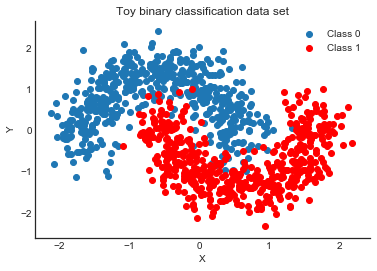

In [3]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

In [4]:
# 2 hidden layerr & 5 neurons
def construct_nn(ann_input, ann_output):
    n_hidden = 5 # num_neurons

    # Initialize < random weights > between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1,
                                 shape=(X.shape[1], n_hidden),
                                 testval=init_1) # testval:초기값 넣기

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1,
                                shape=(n_hidden, n_hidden),
                                testval=init_2)

        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sd=1,
                                  shape=(n_hidden,),
                                  testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input,
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1,
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2,
                                              weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out',
                           act_out,
                           observed=ann_output, # Y값
                           total_size=Y_train.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network

# Trick: Turn inputs and outputs into shared variables.
# It's still the same thing, but we can later change the values of the shared variable
# (to switch in the test-data later) and pymc3 will just use the new data.
# Kind-of like a pointer we can redirect.
# For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)
neural_network = construct_nn(ann_input, ann_output)

## Variational Inference : Scaling model complextiy

In [5]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42)) # np.randomState 와 비슷

In [6]:
%%time

with neural_network:
    inference = pm.ADVI() # 자동 변분 추론 
    approx = pm.fit(n=30000, method=inference)

Average Loss = 174.62: 100%|██████████| 30000/30000 [00:25<00:00, 1154.15it/s]
Finished [100%]: Average Loss = 174.55


CPU times: user 36.9 s, sys: 10.2 s, total: 47 s
Wall time: 31.1 s


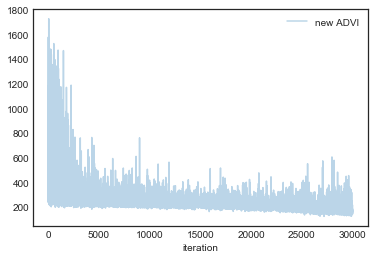

In [8]:
# 목적함수
plt.plot(inference.hist, label='new ADVI', alpha=.3)
plt.legend()
plt.xlabel('iteration');

In [7]:
trace = approx.sample(draws=5000)

In [10]:
# create symbolic input
x = T.matrix('X')
# symbolic number of samples is supported, 
# we build vectorized posterior on the fly
n = T.iscalar('n')
# Do not forget test_values or set theano.config.compute_test_value = 'off'
x.tag.test_value = np.empty_like(X_train[:10])
n.tag.test_value = 100
_sample_proba = approx.sample_node(neural_network.out.distribution.p,
                                   size=n,
                                   more_replacements={ann_input: x})

# It is time to compile the function
# No updates are needed for Approximation random generator
# Efficient vectorized form of sampling is used
sample_proba = theano.function([x, n], _sample_proba)

# Create bechmark functions
def production_step1():
    ann_input.set_value(X_test)
    ann_output.set_value(Y_test)
    with neural_network:
        ppc = pm.sample_ppc(trace, samples=500, progressbar=False)

    # Use probability of > 0.5 to assume prediction of class 1
    pred = ppc['out'].mean(axis=0) > 0.5
    # ppc : 모델을 검증하는 좋은 방법입니다. 
    # 아이디어는 사후에서 끌어온 매개 변수를 사용하여 모델에서 데이터를 생성하는 것입니다.
    #  PPC가 모델에서 생성 된 데이터가 실제 분포에서 생성 된 데이터에서 벗어나는 정도를 분석한다고 약간 말할 수 있습니다. 
    # 따라서 종종 예를 들어, 사후 분포가 근원 분포에 근접하는지 알고 싶을 것입니다. 

def production_step2():
    sample_proba(X_test, 500).mean(0) > 0.5

In [13]:
%timeit production_step1()

160 ms ± 8.65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%timeit production_step2()

35 ms ± 1.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
pred = sample_proba(X_test, 500).mean(0) > 0.5

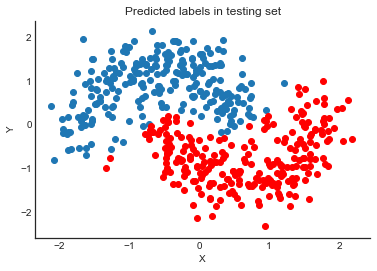

In [16]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [17]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Accuracy = 93.8%


### look at what the clf has learned

In [19]:
grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [20]:
ppc = sample_proba(grid_2d ,500)

Probability surface

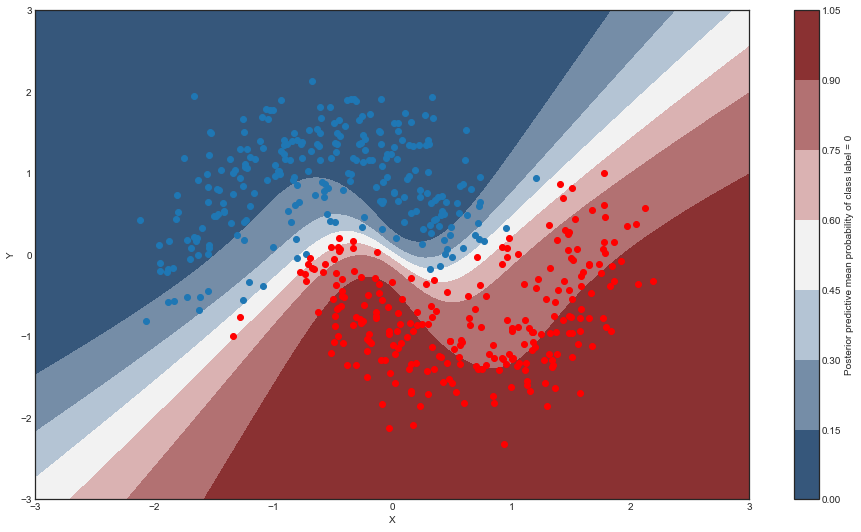

In [21]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

### Uncertainty in predicted value

지금까지 우리가 보여준 모든 것은 베이지안이 아닌 신경망으로 할 수있었습니다. 
각 등급 레이블에 대한 사후 예측의 평균은 최대 우도 예측 값과 동일해야합니다. 
그러나 우리는 우리 예측의 불확실성을 이해하기 위해 후방 예측의 표준 편차를 볼 수 있습니다. 
다음은 그 모습입니다.

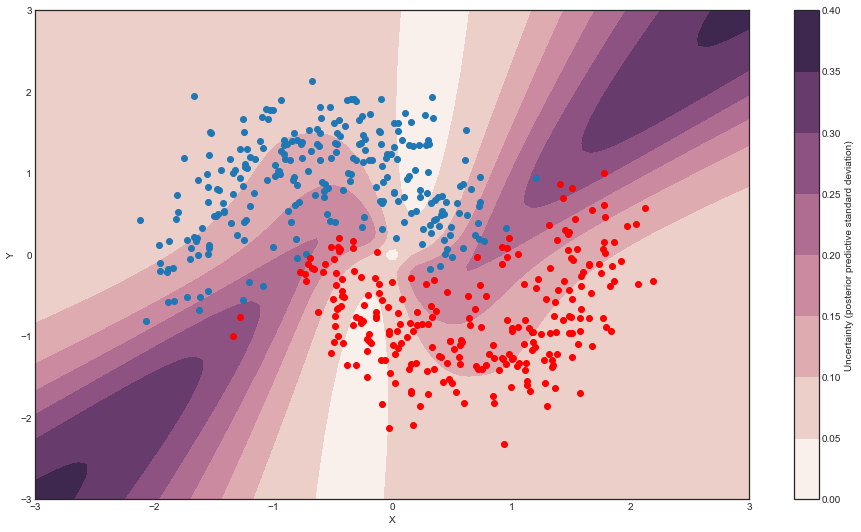

In [23]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

### Mini-batch ADVI

In [24]:
minibatch_x = pm.Minibatch(X_train, batch_size=50)
minibatch_y = pm.Minibatch(Y_train, batch_size=50)

neural_network_minibatch = construct_nn(minibatch_x, minibatch_y)

with neural_network_minibatch:
    approx = pm.fit(40000, method=pm.ADVI())

Average Loss = 209.42: 100%|██████████| 40000/40000 [00:27<00:00, 1446.70it/s]
Finished [100%]: Average Loss = 209.53


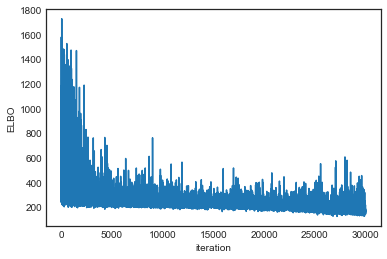

In [25]:
plt.plot(inference.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration');
# 더 빨리 수렴

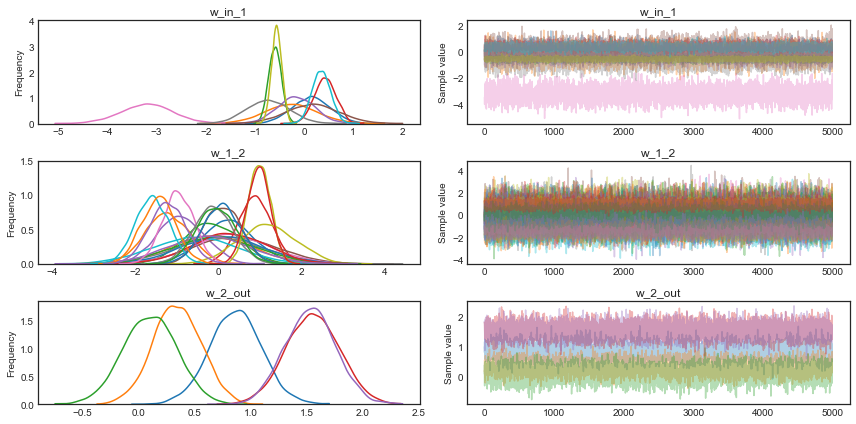

In [26]:
pm.traceplot(trace); # 신경망 가중치에 대한 불확실성